# A Brief Introduction

Underdogs are a cornerstone of our narrative tradition. No matter the venue, when a scrappy upstart comes along and topples an overwhelming favorite, it provides a glimmer of hope that we too can pick up our slingshots and slay Goliath. 

However, to the casual observer, these events might seemingly occur at random. Without the benefit of hindsight, is there a way to identify characteristics in either team's performance that might point us to what the special sauce is that fuels these magic moments?

To answer that, we'll look at Hugot Mathien's soccer database hosted [here](https://www.kaggle.com/hugomathien/soccer) on Kaggle. It contains data about the matches, players, and teams of European club soccer for more than a decade. What's really great is its inclusion of two interesting feature sets: gambling odds, and the attributes of each player in the popular soccer video game FIFA. 

In working our way through the dataset, we'll clean the data, discuss a precise definition of an upset, wrangle our data to get there, and lastly, uncover what, if any, are the key ingredients to an upset in the making. 

# Data Wrangling.

We're going to make use of this expansive dataset in a number of ways, but we can't just take it off the shelf. As such, this step in the process will really have two subcomponents: munging our existing data, and using it to derive new characteristics that we can use to define an upset. We'll get to that second bit later, but first, we're going to have to do a bit of housekeeping. 

For one, the data is spread out across several tables. For our analysis, we're particularly interested in two: the Match tables and the Player Attributes tables. I'll talk about each a little bit more, but the Match table will be where we do most of our work.

We'll start by just importing both the packages we need, as well as the data from the SQLite database where it lives into one large Pandas dataframe:

In [325]:
# Import in our existing data
import pandas as pd
from IPython.display import display
import sqlite3
from datetime import datetime
import numpy as np

conn = sqlite3.connect('database.sqlite')
match_df = pd.read_sql_query('select * from Match;', conn)

Taking a look deeper, we can pull up a lengthy table that contains information about the match itself, the X and Y coordinates representing the position each player took in formation for the match, which player was which in that formation, as well as the gambling odds. The odds are provided in sets of three for each sportsbook: home, away, and draw (H, A, and D respectively), each prefaced by shorthand for each provider (e.g. B365, BW, IW, LB, etc).

In [326]:
match_df.dtypes

id              int64
country_id      int64
league_id       int64
season         object
stage           int64
               ...   
GBD           float64
GBA           float64
BSH           float64
BSD           float64
BSA           float64
Length: 115, dtype: object

For what we're interested today, we're mainly going to focus on the following sets of columns:

- Those which provide the basic information about the match (e.g. the match date, the home team, the away team, and the goals scored for each)
- The actual players on each team, but not the X and Y of the positions in which they played.
- The gamblings odds for each match. 

Before we can get into why, let's just clean our data in these columns so that it's properly used.

## Cleaning Our Data

### Clearing NaNs: Betting Odds
A dataset with this many moving pieces has several issues to take care of. First and foremost, we're only going to need matches where we can actually deduce what the probability each team wins goes in was.

However, we can still get *some* information from the odds of just one provider, so we're going to drop all rows where we have *no* betting odds data from any of our providers. These odds are in the last thirty columns in the data frame, so we can drop any rows where *all* thirty columns are blank, revealing that our number of matches has dropped from the 25978 listed above:

In [327]:
drop_cols = match_df.columns[-30:]
match_df = match_df.dropna(axis=0, how='all', subset=drop_cols)
match_df.shape

(22597, 115)

### Clearing NaNs: Player Data
There are also some matches where there are no players whose attributes we can access, represnted similarly as a NaN. We're going to have to drop those too. For expediency, I'm going to simply do the same thing as above, this time using a simple regular expression to capture the player columns we need.

However, this time, whenever *any* player on a team data is missing, we'll drop the row, as we want to only compare full teams against other full teams, otherwise, the attribute comparisons won't come from datasets of the same size, leading to us drawing conclusions from incomplete data:

In [328]:
drop_cols = match_df.filter(regex=('(?:home|away)_player_\d+$')).columns
match_df = match_df.dropna(axis=0, how='any', subset=drop_cols)
match_df.shape

(19694, 115)

### Modifying Datatypes: Match Dates
Lastly, as I'll discuss later, we're going to need to do some date time math. To make sure our future calculations are right, we're going to need to cast the column that represents when the match took place as date time object. With a quick look at the Pandas documentation, we can see that a dtype of 'O' represents an object rather than a date time, which is what we've got now:

In [329]:
match_df['date'].dtype

dtype('O')

So, instead, let's just recast that column as a datetime object. A quick look at the overall info for the dataset shows us the new datetime64 entry:

In [330]:
match_df['date'] = pd.to_datetime(match_df['date'])
match_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19694 entries, 145 to 24556
Columns: 115 entries, id to BSA
dtypes: datetime64[ns](1), float64(96), int64(9), object(9)
memory usage: 17.4+ MB


### Modifying Data: Pulling in team names
While we could definitely work with the API IDs provided by the data, pulling in the team names from the separate 'Teams' table in the database will provide us with a little more insight into the teams playing at a glance. 

In [331]:
teams = pd.read_sql_query('select * from Team;', conn)
teamdict = dict(zip(teams['team_api_id'], teams['team_long_name']))
match_df['home_team_name'] = match_df.loc[:, ['home_team_api_id']].replace(teamdict)
match_df['away_team_name'] = match_df.loc[:, ['away_team_api_id']].replace(teamdict)
match_df.iloc[:5, -2:]

,home_team_name,away_team_name
145,KV Mechelen,KRC Genk
153,KSV Cercle Brugge,Club Brugge KV
155,RSC Anderlecht,SV Zulte-Waregem
162,KV Mechelen,RSC Anderlecht
168,SV Zulte-Waregem,KSV Roeselare


## Wrangling Our Data 
### Defining an Underdog
What we've got right now doesn't explicitly tell us how large the odds that a team overcame are. Instead, we've got [decimal odds](https://www.sbo.net/strategy/decimal-odds/). These let us know what we can multiply the amount we're willing to wager to determine how much we'd stand to win. For example, if we've got odds of 2.00, and we bet \\$100, we'd stand to win \\$200. 

What's neat about these is that they also represent the oddmaker's guess about how likely each event (a home win, a draw, and an away win) really are. We can use a simple formula to determine what's known as the ["implied probability"](https://help.smarkets.com/hc/en-gb/articles/214058369-How-to-calculate-implied-probability-in-betting) that each event will occur. In the formula below, $d_0$ represents the decimal odds for a given event.

\begin{equation}
P(event) = 100 * (1/d_0)
\end{equation}

However, it is noteworthy that these are not exact representations of what the bookmakers feel the likelihood of each event really is. If that were the case, you'd expect the probability of every possible outcome (a home win, and away win, and a draw) to sum to 1. They do not. All bookies include what's known as an ["over-round"](https://stats.stackexchange.com/questions/140269/how-to-convert-sport-odds-into-percentage), in order to stack the deck against the person placing bets in order to ensure their sportsbook is profitable. Since we can't know what factors the bookies used, as they are continually varied to ensure a continual edge, we'll instead do our best to mitigate that variance in the existing data by averaging all of the probabilities we do have together to get a much better look at what the odds really were for a given match. 


The first thing we'll have to do is actually calculate for each firm the probabilites they estimate:


In [332]:
# grab the columns that represent the odds, and create our implied odds
betting_cols = match_df.iloc[:, -32:-2].copy()
for col in betting_cols.columns:
    betting_cols['{}_prob'.format(col)] = 100 * (1 / match_df[col])

# examine our odds for our first sportsbook
betting_cols.iloc[:, -30:-27]

,B365H_prob,B365D_prob,B365A_prob
145,33.333333,29.411765,43.478261
153,35.714286,31.250000,42.194093
155,71.428571,22.222222,12.500000
162,22.222222,27.777778,57.142857
168,57.142857,28.571429,21.052632
...,...,...,...
24552,63.694268,26.315789,15.384615
24553,44.444444,30.769231,29.411765
24554,65.359477,25.000000,14.285714
24555,43.478261,30.769231,30.769231


Now we've got a multide of probabilites for each outcome. Now comes two important decisions I made in determining how to proceed:
1. We're going to ignore draws. While unexpected draws definitely deflate the side who was expecting to win, they also aren't an "upset" in the true sense of the word.
2. We're going to calculate the gap between the two teams *before* taking the average of each sportsbook. We'll do this in an attempt to prevent one particular bookmaker's odds for one particular outcome from swaying an average calculation.

Bearing this in mind, let's calculate those gaps!

In [333]:
# get the name of every sportsbook
betting_firms = match_df.columns[-30:-2].str[:-1].unique()

# calculate the probability gap for every sportsbook
for firm in betting_firms:
    betting_cols['{}_prob_gap'.format(firm)] = betting_cols['{}H_prob'.format(firm)] \
        - betting_cols['{}A_prob'.format(firm)]

# examine the different probability gaps for three different sportsbooks
betting_cols.iloc[:, -10:-7]

,B365_prob_gap,BW_prob_gap,IW_prob_gap
145,-10.144928,-11.556240,-9.740260
153,-6.479807,-13.196481,-9.740260
155,58.928571,62.962963,59.788360
162,-34.920635,-37.546934,-35.014006
168,36.090226,42.698020,36.796537
...,...,...,...
24552,48.309652,48.309652,40.197897
24553,15.032680,10.295127,14.204545
24554,51.073763,49.131514,43.981481
24555,12.709030,9.219858,5.303030


With gaps in hand, the last step is to take the average across each row, ignoring sportsbooks who didn't offer any odds, and reinsert them back into our main dataframe as a new column:

In [334]:
prob_gaps = betting_cols.iloc[:, -10:].copy()
prob_gaps['avg_prob_gap'] = prob_gaps.mean(axis=1)
match_df['avg_prob_gap'] = prob_gaps['avg_prob_gap']
match_df['avg_prob_gap']

145      -8.786338
153     -10.692869
155      60.878682
162     -35.056567
168      38.786790
           ...    
24552    47.300703
24553    12.806254
24554    49.319345
24555    10.560035
24556    14.478712
Name: avg_prob_gap, Length: 19694, dtype: float64

Looking above, we can see that some matches are positive and some are negative. In this case, we've chosen to keep the sign on our resulting values so that we can know implicitly who won the match. 

Since we always taken the odds of a home victory, and subtracted the odds of an away victory, if that number is negative, then the away team was favored. Conversely, if the number was positive, the home team was favored.

Using this, combined with the goal information originally provided by the dataset, we can add a new column to our dataframe using a lambda function which tells us whether or not the match was an upset.

More explicitly, we know a match is an upset if it meets one of the two following criteria:

- The average probability gap is positive and the away team won the game outright.
- The average probability gap is negative and the home team won the game outright.

This then allows us to show what percentage of our dataset is comprised of upsets:

In [335]:
# identify the upsets and sort them so that the largest upsets are placed highest on the table. 
match_df['upset'] = match_df.apply(lambda x: True if((x['avg_prob_gap']>0)&(x['away_team_goal']>x['home_team_goal'])) or ((x['avg_prob_gap']<0)&(x['home_team_goal']>x['away_team_goal'])) else False, axis=1)
print(format(match_df['upset'].sum()/match_df.shape[0], "%"))

21.564944%


Likewise, we can also add a new column identifying the winning team by looking at the number of goals scored. This will come in handy when we want to separate what makes a winner:

In [336]:
# identify the winners of each match
match_df['winner'] = match_df.apply(lambda x: 'Home' if(x['home_team_goal']>x['away_team_goal']) else ('Away' if x['home_team_goal']<x['away_team_goal'] else 'Draw'), axis=1) 
match_df['winner']

145      Home
153      Away
155      Home
162      Home
168      Draw
         ... 
24552    Home
24553    Home
24554    Home
24555    Draw
24556    Home
Name: winner, Length: 19694, dtype: object

### Pulling in team characteristics.
Speaking of identifying winners, we'll now have to pull in the characteristics of each team that we actually want to analyze. As we saw from the description of the table above, this dataframe doesn't actually have the characteristics of the players in it. Instead, it only shows the IDs for who was playing in the match. If we want to know what actually *defined* the teams who played, we're going to need to do quite a bit of leg work. 

Firstly, we're going to need another dataframe, this time, containing the information from the player attributes table mentioned when we started:

In [337]:
# get our raw table from the SQLite db
player_attributes = pd.read_sql_query('select * from Player_Attributes;', conn)

As above, this doesn't come without a little touching up itself. In this case, this dataframe also has a date stamp that's stored as a string, which we'll have to convert to a datetime object:

In [338]:
# make sure that our dates are properly formatted date time objects
player_attributes['date'] = pd.to_datetime(player_attributes['date'])

Additionally, there are a couple of attributes in the data frame that we can throw out, namely, the player's preferred foot, their "attacking work rate" and their "defensive work rate". These aren't measures of the players' skills, but are defined in the dataset as attributes that FIFA uses interally. While the foot you use might be an interesting characteristic, it won't map neatly with the rest of the dataset, all of whom the values are scaled from 0-100, with 100 being the best for each attribute. For those reasons, we'll throw them out, and get a list of the columns we'll be wrangling in a moment.

In [339]:
# grab the list of player attributes that are numerical that we can analyze
attrs = list(player_attributes.columns[4:])
removals = ['preferred_foot', 'attacking_work_rate', 'defensive_work_rate']
attrs = [attr for attr in attrs if attr not in removals]

One last piece of information we need to be aware of is the format of the player attributes table. This dataset actually represents the live updating statistics that FIFA uses to ensure their players get the most accurate game experience possible. As such, many players have multiple rows, each with a date corresponding to the sample time, and an overall rating that changed with the player's real world performance:

In [340]:
player_attributes[player_attributes['player_api_id']==39902].loc[:, ['player_api_id', 'date', 'overall_rating']]

,player_api_id,date,overall_rating
183968,39902,2012-08-31,78.0
183969,39902,2012-02-22,81.0
183970,39902,2011-08-30,81.0
183971,39902,2011-02-22,81.0
183972,39902,2010-08-30,83.0
183973,39902,2009-08-30,83.0
183974,39902,2009-02-22,78.0
183975,39902,2008-08-30,77.0
183976,39902,2007-08-30,78.0
183977,39902,2007-02-22,80.0


This means that we're actually going to have to take a sample of the team's performance by averaging each of the characteristics from the time that was closest to the match we actually want to observe. I've laid this out in detail in the function below. 

While Pandas is best at vectorizing operations, I'm still working towards implementing a solution that doesn't iterate through our massive dataframe line by line. Until I do, I've defined a function that will provide us with the relevant information that we need. The comments in the code explain more in detail what it does, but here's the break down in short:

- We fetch the players from the winning and losing teams
- We create two smaller dataframes that filter down the main attributes table, one representing all the samples of all the charateristics of the winning team and losing team respectively.
- We then find the best sample for each player by taking the difference between the date the match was played and the dates of the samples for each player in the dataset. 
- We then average together the attributes for each player on the team.
- With the characteristics of the winning team and the losing team calculated as a set of columns, we then append them back into our main match dataframe.

If that seems like a lot for 20k matches, it is. It is also not particularly computationally efficient. Even with my new Ryzen processor, this still took about 20 minutes to complete, but it does work. Let's take a look at the final dataframe, and after all this, get down to business.

In [341]:
%%timeit -n1

def process_match(index, match, winner):
    # get the players from the winning and losing teams
    if winner == 'Home':
        w_players = match[55:66].values.astype(int)
        l_players = match[66:77].values.astype(int)
    elif winner == 'Away':
        w_players = match[66:77].values.astype(int)
        l_players = match[55:66].values.astype(int)
    else:
        return
        
    # grab the attribute rows for both home and away players and separate them out into different dataframes
    win_crit = player_attributes['player_api_id'].isin(w_players)
    los_crit = player_attributes['player_api_id'].isin(l_players)
    w_df = player_attributes[win_crit].copy()
    l_df = player_attributes[los_crit].copy()
    
    # in the separate dfs, find the gap between the match played and the samples provided by the attributes file
    w_df['dist_to_match'] = abs(match['date'] - w_df['date'])
    l_df['dist_to_match'] = abs(match['date'] - l_df['date'])
    
    # fetch the rows representing the closest sample to when the game was played
    w_rows = [w_df.query('player_api_id == {}'.format(p))['dist_to_match'].idxmin()+1 for p in w_players]
    l_rows = [l_df.query('player_api_id == {}'.format(p))['dist_to_match'].idxmin()+1 for p in l_players]
    w_df = w_df.query('id in {}'.format(w_rows)).copy()
    l_df = l_df.query('id in {}'.format(l_rows)).copy()
    
    # update the original updates dataframe with the average results for each metric from the day the game was played
    for attr in attrs:
        match_df.loc[index, 'w_avg_{}'.format(attr)] = w_df['{}'.format(attr)].mean()
        match_df.loc[index, 'l_avg_{}'.format(attr)] = l_df['{}'.format(attr)].mean()
        
for index, match in match_df.iterrows():
    process_match(index, match, match['winner'])

16min 59s ± 2.8 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Exploratory  Data Analysis
And after all that, we've got something we can work with! Before we begin, let's actually take a look at some of the top upsets we've got listed, and see if our data wrangling pointed us in the right direction. I'm just going to select a few columns here and take a look at the top five biggest upsets in our dataset: 

In [342]:
match_df['abs_prob_gap'] = match_df['avg_prob_gap'].abs()
cols = ['home_team_name', 'away_team_name', 'upset', 'winner', 'date', 'home_team_goal', 'away_team_goal', 'abs_prob_gap']
match_df.sort_values(by=['abs_prob_gap'], ascending=False)[match_df['upset'] == True].loc[:,cols].head()

/home/andrewhunt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


,home_team_name,away_team_name,upset,winner,date,home_team_goal,away_team_goal,abs_prob_gap
22389,FC Barcelona,Hércules Club de Fútbol,True,Away,2010-09-11,0,2,89.759765
23966,FC Barcelona,Málaga CF,True,Away,2015-02-21,0,1,85.360065
10094,FC Bayern Munich,1. FSV Mainz 05,True,Away,2016-03-02,1,2,83.269889
2972,Manchester United,Blackburn Rovers,True,Away,2011-12-31,2,3,82.873879
23566,FC Barcelona,Valencia CF,True,Away,2014-02-01,2,3,82.644123


Sure enough, a quick google search reveals the shock and awe that Hercules Club brought to La Liga by dethroning a then unbeaten at home Barcelona team [at Camp Nou](https://www.goal.com/en-us/news/88/spain/2010/09/13/2115667/nelson-valdez-the-homeless-herculean-who-downed-barcelona).

Now. Let's ask our questions, starting with the obvious: 

### Research Question 1: What features are most elevated amongst teams who pull off the largest upsets? 

For this multi-variable question, let's separate out the data to find out what teams actually did pull off the top 1% of all upsets. Starting with getting the very cream of the crop, the top 1% of upsets:

In [343]:
toppercentile = match_df[match_df['upset'] == True].loc[:,['abs_prob_gap']].quantile(.99)[0]
top_upsets = match_df[(match_df['upset'] == True)&(match_df['abs_prob_gap']>toppercentile)].sort_values(by=['abs_prob_gap'], ascending=False)

Now that we have that information, we can pull out the characteristics of the winners (which we know were all of our upset teams):

In [344]:
top_upset_avg_attrs = top_upsets.filter(regex=("w_avg_*"))
top_upset_avg_attrs.mean().values

array([70.1627907 , 74.03171247, 55.82663848, 47.05285412, 58.3615222 ,
       63.71458774, 46.45496829, 58.36997886, 52.28160677, 48.98097252,
       58.7653277 , 63.57928118, 66.13742072, 67.205074  , 64.72917548,
       68.04651163, 64.51606765, 60.65961945, 67.42536998, 68.19027484,
       69.69767442, 51.19661734, 64.17336152, 54.90909091, 54.20295983,
       58.90866808, 52.37632135, 51.43763214, 54.72515856, 52.15877378,
       15.80972516, 16.24735729, 18.31712474, 16.47357294, 16.44820296])

And can compare those to the average team who did not pull off the upset. A horizontal bar graph here will highlight the distance between the upsetters and the average team. The further to the right, the better the team that pulled the upset, the further to the left, the better the average team:

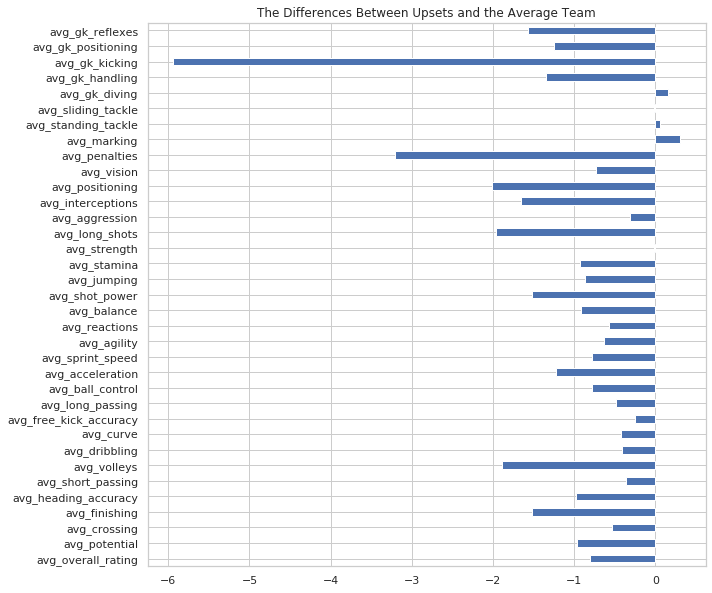

In [345]:
loser_upset_avg_attrs = match_df[match_df['upset'] == False].filter(regex=('l_avg_*'))
upsets = top_upset_avg_attrs.mean().values 
non_upsets = loser_upset_avg_attrs.mean().values
column_names = [x[2:] for x in list(loser_upset_avg_attrs.columns.values)]
gaps_df = pd.DataFrame([upsets, non_upsets], columns=column_names)
gaps_df = gaps_df.T
gaps_df['gap'] = gaps_df.iloc[:, 0] - gaps_df.iloc[:, 1]
gaps_df.iloc[:, 2].plot(kind='barh', figsize=(10, 10), title='The Differences Between Upsets and the Average Team');

Unfortunately, this does tell us a story, just not a very compelling one. The gap between these two teams is less significant than previously imagined. In fact, the teams that *didn't* pull the upset are better than the teams that teams in every single category, save three: goalkeeper diving, standing tackling, and their ability to mark their opponents on the field. They're also exactly the same when it comes to sliding tackles. 

What else does this tell us? A few hypotheses:

- Perhaps that average team performance does not predict  the outcome of one specific game. Many upsets have a hero, a player who plays well above their typical performance in any other game. That means that even an average look at their performance might not demonstrate their value in a particular game, doubly diminished by averaging their individual performance with the ten others on the pitch with them.
- Perhaps characteristics are not the deciding factor in who pulls an upset. It could be that some of the very things we didn't consider, such as team positioning and placement, as well as the individual tactics and plays drawn up by the coach for that particular game weigh heavily. This is often the case in college football, where teams can build their entire season around preparing for an archrival, studying their specific strategies and players in order to get the upper hand when the rest of the world least expects it.

Let's look at something else instead, and see if we can find results, hopefully ones that are slightly less disheartening.

### Research Question 2: Which teams and leagues are most likely to be upset victims?
Perhaps this might be a little more heartening for the underdog. If they saw a daunting team coming up their schedule, what from their recent past could provide them the hope that they too, might be immortalized by an upset? Let's assemble a new dataframe and break it down team by team and league by league. With many teams in the dataset, comparing the top leagues in a pie graph will show their relative ratios, whilst a bar graph should provide us with enough information regarding which teams are the usual suspects to be upset:

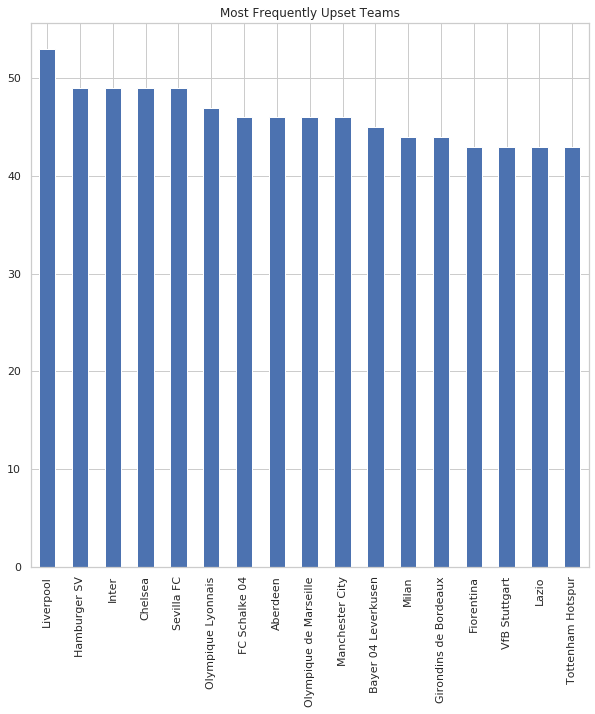

In [346]:
home_team_victims = match_df[(match_df['upset'] == True)&(match_df['winner']=='Away')].groupby(['home_team_name'])['id'].count()
away_team_victims = match_df[(match_df['upset'] == True)&(match_df['winner']=='Home')].groupby(['away_team_name'])['id'].count()

counts = pd.DataFrame([away_team_victims, home_team_victims]).T
counts.columns = ['away_upsets', 'home_upsets']
counts.fillna(value=0, inplace=True)
counts['total_upsets'] = counts['away_upsets'] + counts['home_upsets']
counts = counts.sort_values(by=['total_upsets'], ascending=False)
counts['upset_ratio'] = counts['total_upsets'] / counts['total_upsets'].sum()
counts.iloc[:17, 2].plot(kind='bar', figsize=(10,10), title="Most Frequently Upset Teams");

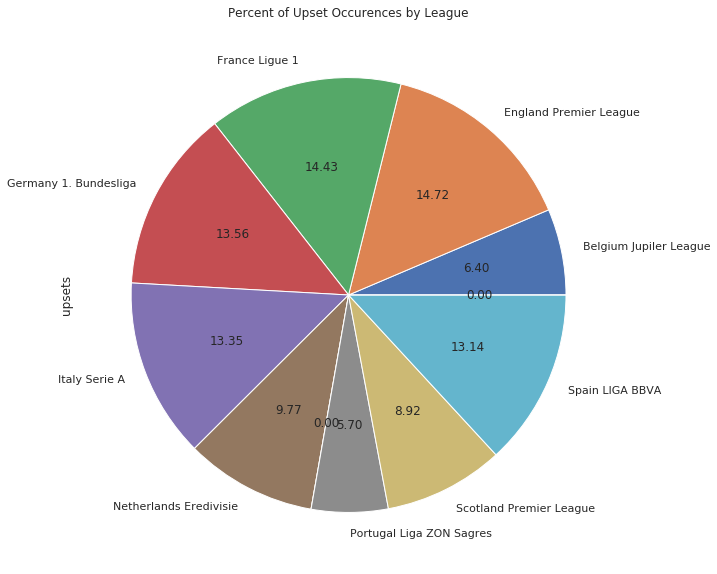

In [347]:
league_home_team_victims = match_df[(match_df['upset'] == True)&(match_df['winner']=='Away')].groupby(['league_id'])['id'].count()
league_away_team_victims = match_df[(match_df['upset'] == True)&(match_df['winner']=='Home')].groupby(['league_id'])['id'].count()

league_home_team_victims

leagues = pd.read_sql_query('select country_id, name from League;', conn)
leagues = leagues.set_index('country_id')
leagues['home_upsets'] = league_home_team_victims
leagues['away_upsets'] = league_away_team_victims
leagues.fillna(value=0, inplace=True)
leagues['upsets'] = leagues['home_upsets'] + leagues['away_upsets']
leagues = leagues.set_index('name')
leagues['upsets'].plot(kind='pie', autopct='%.2f', title="Percent of Upset Occurences by League");

Unfortunately, some of these teams have histories riddled with bad luck and poor decision making, and in some ways, are the exact teams one might expect to find atop this list. However, the occurences by league doesn't show a clear leader for which league has the most upsets, and even still, this analysis wouldn't be able to determine conclusively if there was a statistical signifiance to that gap. It could also be a limitation of our dataset that this doesn't include all of the competitions these teams participate in, that we're not able to fully draw comparisons, as well as a lack of hypothesis testing to determine if the gaps between our leagues are statistically significant. 

### In Conclusions
Unfortunately, in many ways, the more things change, the more they stay the same, and that appears to be true for our dataset as well. Perhaps further testing could be done to more neatly isolate changes in player performance leading up to a match that was an upset, and a dataset that included all the matches, including international competitions, might point us more in the direction of teams that are vulnerable. Additionally, as goes for all the analysis we've done, hypothesis testing might lend more rigor to our conclusions that either league, team, or even player characteristics have an impact on predicting our final result.